In [1]:
import os
from math import ceil

import cv2
import matplotlib.pyplot as plt

import read_video
import image_slicing as img_sl

# 1. Video frames stitching

In [2]:
test_video_path = os.path.join(
    '/home/maksim/Desktop/ITMO Lectures/3. CV DL and CV',
    'Code/test _video/video 3/video_3_1.mp4'
)

In [3]:
video_frames = read_video.read_video(test_video_path, step=24)

In [4]:
video_frames.shape

(13, 720, 1280, 3)

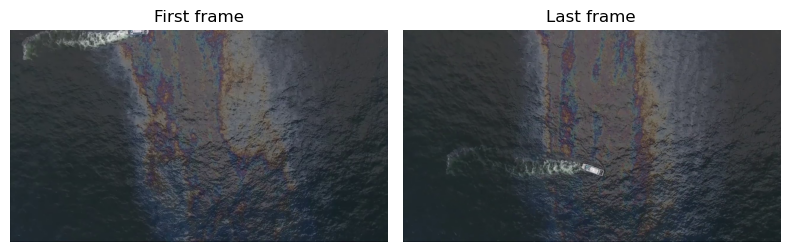

In [5]:
titles = ['First frame', 'Last frame']
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
for ax_i, img_i in enumerate([0, -1]):
    axs[ax_i].imshow(video_frames[img_i])
    axs[ax_i].axis('off')
    axs[ax_i].set_title(titles[ax_i])
plt.tight_layout()
plt.show()

In [6]:
stitcher = cv2.Stitcher.create(cv2.Stitcher_SCANS)

In [7]:
status, output = stitcher.stitch(video_frames)

In [8]:
if status == 0:
    print('Images stitched successfully.')
else:
    print(f'Error status: {status}')

Images stitched successfully.


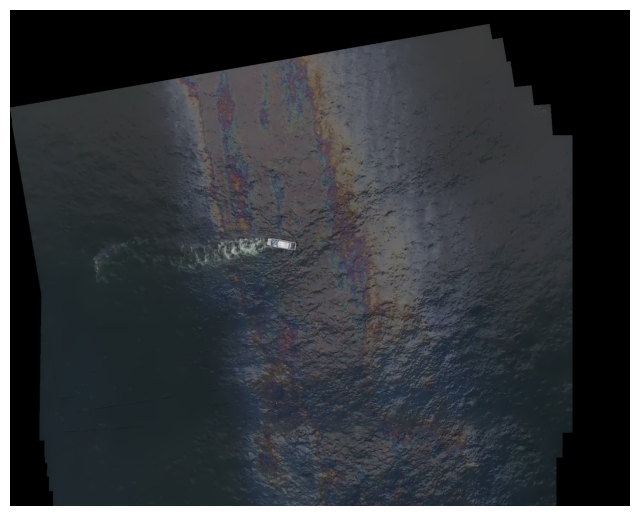

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(output)
ax.axis('off')
plt.show()

# 2. Sub frames extraction

## Preprocess

In [10]:
output_crop = img_sl.crop_image_by_edges(output)

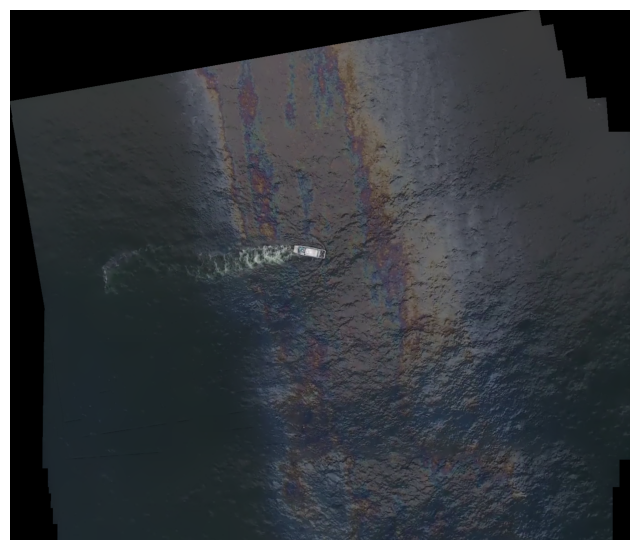

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(output_crop)
ax.axis('off')
plt.show()

## Image slicing

In [12]:
w_size = 334
output_crop_slices = img_sl.slice_image(output, w_size)

output_crop_slices.shape

(4, 5, 3, 334, 334)

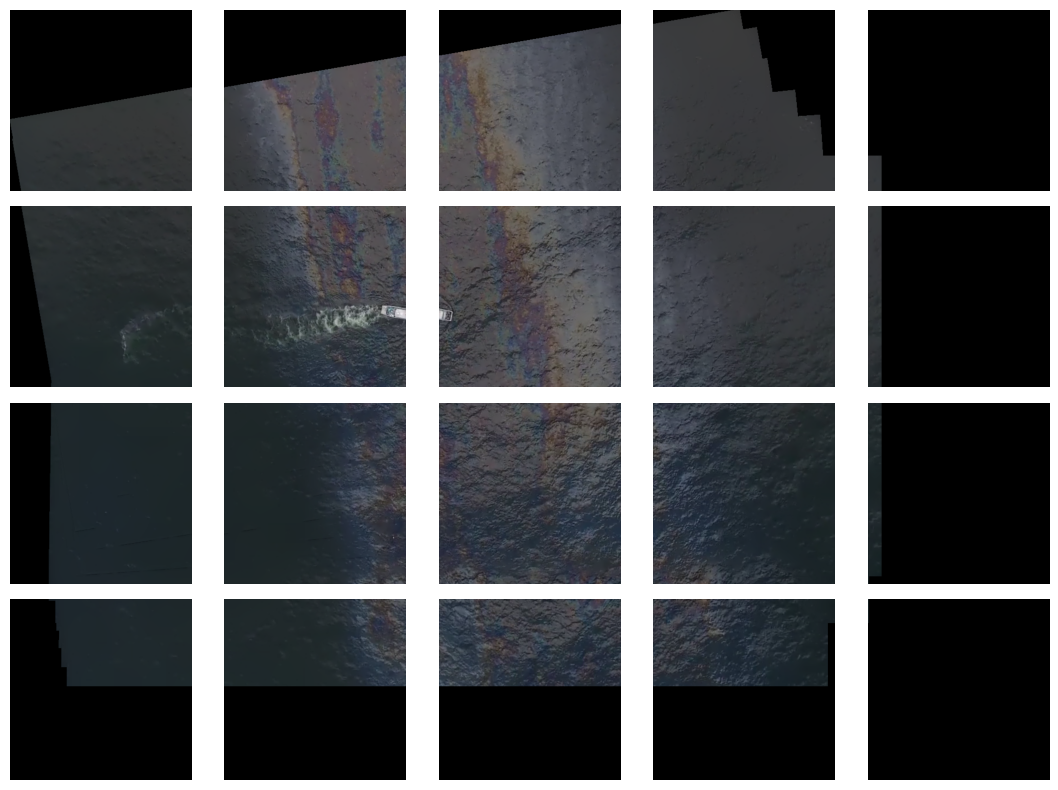

In [13]:
rows, cols, channels, _, _,  = output_crop_slices.shape

fig, axs = plt.subplots(rows, cols, figsize=(11, 8))

for i in range(rows):
    for j in range(cols):
        axs[i, j].imshow(
            output_crop_slices[i, j]
            .transpose(1, 2, 0)
        )
        axs[i, j].axis('off')
        
plt.tight_layout()
plt.show()

In [14]:
# batch of (N, C, H, W):
slices_batch = output_crop_slices.reshape(
    rows*cols, channels, w_size, w_size
)

slices_batch.shape

(20, 3, 334, 334)

## Collect batch of slices into image

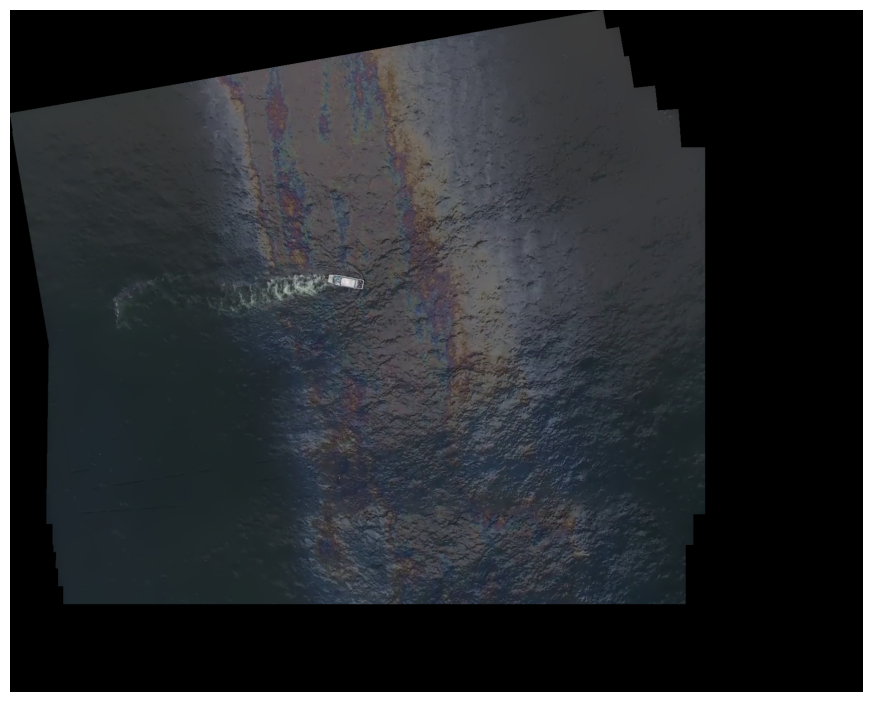

In [15]:
image_from_batch = img_sl.batch2image(slices_batch, rows, cols)

fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(image_from_batch)
ax.axis('off')
plt.show();

# 3. Pipeline

In [16]:
# Init:
test_video_path = os.path.join(
    '/home/maksim/Desktop/ITMO Lectures/3. CV DL and CV',
    'Code/test _video/video 3/video_3_1.mp4'
)
stitcher = cv2.Stitcher.create(cv2.Stitcher_SCANS)
network_img_size = 224

# Video to batch:
video_frames = read_video.read_video(test_video_path, step=24)
status, output = stitcher.stitch(video_frames)
print('From stitching image shape:', output.shape)
output_crop_slices = img_sl.slice_image(output, network_img_size)
rows, cols, channels, _, _,  = output_crop_slices.shape
slices_batch = output_crop_slices.reshape(
    rows*cols, channels, network_img_size, network_img_size
)

print('Batch shape:', slices_batch.shape, '(N, C, H, W)')
print('Predict on batch..')

# Masks from batch into image:
print('Masks have same size as images batch:', slices_batch.shape)
image_from_batch = img_sl.batch2image(slices_batch, rows, cols)
print('Final image shape:', image_from_batch.shape)

From stitching image shape: (1241, 1471, 3)
Batch shape: (42, 3, 224, 224) (N, C, H, W)
Predict on batch..
Masks have same size as images batch: (42, 3, 224, 224)
Final image shape: (1344, 1568, 3)


In [18]:
# cv2.imwrite('test_image.jpg', output_crop)